# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 22.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 19.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 31.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 3.0 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp6 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5246402,-77.5634723,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Nov 19 17:23:34 +0000 2020'
'Thu Nov 19 17:23:33 +0000 2020'
'Thu Nov 19 17:23:30 +0000 2020'
'Thu Nov 19 17:23:29 +0000 2020'
'Thu Nov 19 17:23:24 +0000 2020'
'Thu Nov 19 17:23:20 +0000 2020'
'Thu Nov 19 17:23:19 +0000 2020'
'Thu Nov 19 17:23:11 +0000 2020'
'Thu Nov 19 17:23:10 +0000 2020'
'Thu Nov 19 17:23:10 +0000 2020'
'Thu Nov 19 17:23:03 +0000 2020'
'Thu Nov 19 17:22:56 +0000 2020'
'Thu Nov 19 17:22:47 +0000 2020'
'Thu Nov 19 17:22:47 +0000 2020'
'Thu Nov 19 17:22:41 +0000 2020'
'Thu Nov 19 17:22:34 +0000 2020'
'Thu Nov 19 17:22:31 +0000 2020'
'Thu Nov 19 17:22:22 +0000 2020'
'Thu Nov 19 17:22:09 +0000 2020'
'Thu Nov 19 17:22:08 +0000 2020'
'Thu Nov 19 17:22:04 +0000 2020'
'Thu Nov 19 17:22:02 +0000 2020'
'Thu Nov 19 17:22:02 +0000 2020'
'Thu Nov 19 17:21:50 +0000 2020'
'Thu Nov 19 17:21:48 +0000 2020'
'Thu Nov 19 17:21:41 +0000 2020'
'Thu Nov 19 17:21:39 +0000 2020'
'Thu Nov 19 17:21:37 +0000 2020'
'Thu Nov 19 17:21:31 +0000 2020'
'Thu Nov 19 17:21:26 +0000 2020'
'Thu Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Nov 19 17:17:11 +0000 2020'
'Thu Nov 19 17:17:03 +0000 2020'
'Thu Nov 19 17:17:02 +0000 2020'
'Thu Nov 19 17:17:01 +0000 2020'
'Thu Nov 19 17:16:59 +0000 2020'
'Thu Nov 19 17:16:56 +0000 2020'
'Thu Nov 19 17:16:55 +0000 2020'
'Thu Nov 19 17:16:52 +0000 2020'
'Thu Nov 19 17:16:52 +0000 2020'
'Thu Nov 19 17:16:50 +0000 2020'
'Thu Nov 19 17:16:47 +0000 2020'
'Thu Nov 19 17:16:47 +0000 2020'
'Thu Nov 19 17:16:45 +0000 2020'
'Thu Nov 19 17:16:45 +0000 2020'
'Thu Nov 19 17:16:45 +0000 2020'
'Thu Nov 19 17:16:41 +0000 2020'
'Thu Nov 19 17:16:40 +0000 2020'
'Thu Nov 19 17:16:39 +0000 2020'
'Thu Nov 19 17:16:39 +0000 2020'
'Thu Nov 19 17:16:36 +0000 2020'
'Thu Nov 19 17:16:34 +0000 2020'
'Thu Nov 19 17:16:31 +0000 2020'
'Thu Nov 19 17:16:31 +0000 2020'
'Thu Nov 19 17:16:28 +0000 2020'
'Thu Nov 19 17:16:27 +0000 2020'
'Thu Nov 19 17:16:26 +0000 2020'
'Thu Nov 19 17:16:26 +0000 2020'
'Thu Nov 19 17:16:20 +0000 2020'
'Thu Nov 19 17:16:19 +0000 2020'
'Thu Nov 19 17:16:16 +0000 2020'
'Thu Nov 1

'Thu Nov 19 16:58:48 +0000 2020'
'Thu Nov 19 16:58:44 +0000 2020'
'Thu Nov 19 16:58:30 +0000 2020'
'Thu Nov 19 16:58:26 +0000 2020'
'Thu Nov 19 16:58:26 +0000 2020'
'Thu Nov 19 16:58:23 +0000 2020'
'Thu Nov 19 16:58:22 +0000 2020'
'Thu Nov 19 16:58:21 +0000 2020'
'Thu Nov 19 16:58:21 +0000 2020'
'Thu Nov 19 16:58:18 +0000 2020'
'Thu Nov 19 16:58:08 +0000 2020'
'Thu Nov 19 16:58:07 +0000 2020'
'Thu Nov 19 16:58:04 +0000 2020'
'Thu Nov 19 16:58:00 +0000 2020'
'Thu Nov 19 16:57:59 +0000 2020'
'Thu Nov 19 16:57:46 +0000 2020'
'Thu Nov 19 16:57:44 +0000 2020'
'Thu Nov 19 16:57:32 +0000 2020'
'Thu Nov 19 16:57:27 +0000 2020'
'Thu Nov 19 16:57:22 +0000 2020'
'Thu Nov 19 16:57:21 +0000 2020'
'Thu Nov 19 16:57:04 +0000 2020'
'Thu Nov 19 16:57:02 +0000 2020'
'Thu Nov 19 16:56:50 +0000 2020'
'Thu Nov 19 16:56:27 +0000 2020'
'Thu Nov 19 16:56:09 +0000 2020'
'Thu Nov 19 16:56:07 +0000 2020'
'Thu Nov 19 16:55:52 +0000 2020'
'Thu Nov 19 16:55:49 +0000 2020'
'Thu Nov 19 16:55:40 +0000 2020'
'Thu Nov 1

'Thu Nov 19 16:33:03 +0000 2020'
'Thu Nov 19 16:32:55 +0000 2020'
'Thu Nov 19 16:32:54 +0000 2020'
'Thu Nov 19 16:32:46 +0000 2020'
'Thu Nov 19 16:32:43 +0000 2020'
'Thu Nov 19 16:32:43 +0000 2020'
'Thu Nov 19 16:32:40 +0000 2020'
'Thu Nov 19 16:32:37 +0000 2020'
'Thu Nov 19 16:32:30 +0000 2020'
'Thu Nov 19 16:32:27 +0000 2020'
'Thu Nov 19 16:32:26 +0000 2020'
'Thu Nov 19 16:32:26 +0000 2020'
'Thu Nov 19 16:32:20 +0000 2020'
'Thu Nov 19 16:31:44 +0000 2020'
'Thu Nov 19 16:31:44 +0000 2020'
'Thu Nov 19 16:31:40 +0000 2020'
'Thu Nov 19 16:31:39 +0000 2020'
'Thu Nov 19 16:31:38 +0000 2020'
'Thu Nov 19 16:31:23 +0000 2020'
'Thu Nov 19 16:31:21 +0000 2020'
'Thu Nov 19 16:31:15 +0000 2020'
'Thu Nov 19 16:31:14 +0000 2020'
'Thu Nov 19 16:31:10 +0000 2020'
'Thu Nov 19 16:31:04 +0000 2020'
'Thu Nov 19 16:31:00 +0000 2020'
'Thu Nov 19 16:30:57 +0000 2020'
'Thu Nov 19 16:30:56 +0000 2020'
'Thu Nov 19 16:30:51 +0000 2020'
'Thu Nov 19 16:30:51 +0000 2020'
'Thu Nov 19 16:30:50 +0000 2020'
'Thu Nov 1

'Thu Nov 19 16:09:57 +0000 2020'
'Thu Nov 19 16:09:57 +0000 2020'
'Thu Nov 19 16:09:56 +0000 2020'
'Thu Nov 19 16:09:53 +0000 2020'
'Thu Nov 19 16:09:52 +0000 2020'
'Thu Nov 19 16:09:51 +0000 2020'
'Thu Nov 19 16:09:41 +0000 2020'
'Thu Nov 19 16:09:38 +0000 2020'
'Thu Nov 19 16:09:33 +0000 2020'
'Thu Nov 19 16:09:30 +0000 2020'
'Thu Nov 19 16:09:24 +0000 2020'
'Thu Nov 19 16:09:23 +0000 2020'
'Thu Nov 19 16:09:20 +0000 2020'
'Thu Nov 19 16:09:20 +0000 2020'
'Thu Nov 19 16:09:10 +0000 2020'
'Thu Nov 19 16:09:05 +0000 2020'
'Thu Nov 19 16:08:59 +0000 2020'
'Thu Nov 19 16:08:35 +0000 2020'
'Thu Nov 19 16:08:30 +0000 2020'
'Thu Nov 19 16:08:27 +0000 2020'
'Thu Nov 19 16:08:22 +0000 2020'
'Thu Nov 19 16:08:18 +0000 2020'
'Thu Nov 19 16:08:18 +0000 2020'
'Thu Nov 19 16:08:16 +0000 2020'
'Thu Nov 19 16:08:14 +0000 2020'
'Thu Nov 19 16:08:08 +0000 2020'
'Thu Nov 19 16:08:00 +0000 2020'
'Thu Nov 19 16:07:49 +0000 2020'
'Thu Nov 19 16:07:48 +0000 2020'
'Thu Nov 19 16:07:44 +0000 2020'
'Thu Nov 1

'Thu Nov 19 15:47:52 +0000 2020'
'Thu Nov 19 15:47:46 +0000 2020'
'Thu Nov 19 15:47:45 +0000 2020'
'Thu Nov 19 15:47:13 +0000 2020'
'Thu Nov 19 15:47:10 +0000 2020'
'Thu Nov 19 15:47:03 +0000 2020'
'Thu Nov 19 15:47:01 +0000 2020'
'Thu Nov 19 15:46:57 +0000 2020'
'Thu Nov 19 15:46:56 +0000 2020'
'Thu Nov 19 15:46:46 +0000 2020'
'Thu Nov 19 15:46:38 +0000 2020'
'Thu Nov 19 15:46:04 +0000 2020'
'Thu Nov 19 15:45:56 +0000 2020'
'Thu Nov 19 15:45:56 +0000 2020'
'Thu Nov 19 15:45:55 +0000 2020'
'Thu Nov 19 15:45:35 +0000 2020'
'Thu Nov 19 15:45:35 +0000 2020'
'Thu Nov 19 15:45:27 +0000 2020'
'Thu Nov 19 15:45:27 +0000 2020'
'Thu Nov 19 15:45:20 +0000 2020'
'Thu Nov 19 15:45:14 +0000 2020'
'Thu Nov 19 15:45:12 +0000 2020'
'Thu Nov 19 15:45:08 +0000 2020'
'Thu Nov 19 15:45:04 +0000 2020'
'Thu Nov 19 15:45:04 +0000 2020'
'Thu Nov 19 15:45:00 +0000 2020'
'Thu Nov 19 15:44:49 +0000 2020'
'Thu Nov 19 15:44:47 +0000 2020'
'Thu Nov 19 15:44:35 +0000 2020'
'Thu Nov 19 15:44:32 +0000 2020'
'Thu Nov 1

'Thu Nov 19 15:21:13 +0000 2020'
'Thu Nov 19 15:21:10 +0000 2020'
'Thu Nov 19 15:21:10 +0000 2020'
'Thu Nov 19 15:20:59 +0000 2020'
'Thu Nov 19 15:20:51 +0000 2020'
'Thu Nov 19 15:20:42 +0000 2020'
'Thu Nov 19 15:20:38 +0000 2020'
'Thu Nov 19 15:20:36 +0000 2020'
'Thu Nov 19 15:20:26 +0000 2020'
'Thu Nov 19 15:20:25 +0000 2020'
'Thu Nov 19 15:20:12 +0000 2020'
'Thu Nov 19 15:20:11 +0000 2020'
'Thu Nov 19 15:20:09 +0000 2020'
'Thu Nov 19 15:20:07 +0000 2020'
'Thu Nov 19 15:20:05 +0000 2020'
'Thu Nov 19 15:20:03 +0000 2020'
'Thu Nov 19 15:20:03 +0000 2020'
'Thu Nov 19 15:20:00 +0000 2020'
'Thu Nov 19 15:19:57 +0000 2020'
'Thu Nov 19 15:19:52 +0000 2020'
'Thu Nov 19 15:19:51 +0000 2020'
'Thu Nov 19 15:19:47 +0000 2020'
'Thu Nov 19 15:19:47 +0000 2020'
'Thu Nov 19 15:19:38 +0000 2020'
'Thu Nov 19 15:19:37 +0000 2020'
'Thu Nov 19 15:19:36 +0000 2020'
'Thu Nov 19 15:19:35 +0000 2020'
'Thu Nov 19 15:19:32 +0000 2020'
'Thu Nov 19 15:19:19 +0000 2020'
'Thu Nov 19 15:19:17 +0000 2020'
'Thu Nov 1

'Thu Nov 19 15:02:59 +0000 2020'
'Thu Nov 19 15:02:57 +0000 2020'
'Thu Nov 19 15:02:52 +0000 2020'
'Thu Nov 19 15:02:50 +0000 2020'
'Thu Nov 19 15:02:45 +0000 2020'
'Thu Nov 19 15:02:43 +0000 2020'
'Thu Nov 19 15:02:42 +0000 2020'
'Thu Nov 19 15:02:40 +0000 2020'
'Thu Nov 19 15:02:37 +0000 2020'
'Thu Nov 19 15:02:32 +0000 2020'
'Thu Nov 19 15:02:26 +0000 2020'
'Thu Nov 19 15:02:26 +0000 2020'
'Thu Nov 19 15:02:26 +0000 2020'
'Thu Nov 19 15:02:18 +0000 2020'
'Thu Nov 19 15:02:17 +0000 2020'
'Thu Nov 19 15:02:16 +0000 2020'
'Thu Nov 19 15:02:12 +0000 2020'
'Thu Nov 19 15:02:11 +0000 2020'
'Thu Nov 19 15:02:08 +0000 2020'
'Thu Nov 19 15:02:06 +0000 2020'
'Thu Nov 19 15:02:03 +0000 2020'
'Thu Nov 19 15:02:03 +0000 2020'
'Thu Nov 19 15:01:54 +0000 2020'
'Thu Nov 19 15:01:50 +0000 2020'
'Thu Nov 19 15:01:49 +0000 2020'
'Thu Nov 19 15:01:45 +0000 2020'
'Thu Nov 19 15:01:41 +0000 2020'
'Thu Nov 19 15:01:37 +0000 2020'
'Thu Nov 19 15:01:26 +0000 2020'
'Thu Nov 19 15:01:22 +0000 2020'
'Thu Nov 1

'Thu Nov 19 14:42:43 +0000 2020'
'Thu Nov 19 14:42:42 +0000 2020'
'Thu Nov 19 14:42:25 +0000 2020'
'Thu Nov 19 14:42:06 +0000 2020'
'Thu Nov 19 14:42:05 +0000 2020'
'Thu Nov 19 14:41:59 +0000 2020'
'Thu Nov 19 14:41:45 +0000 2020'
'Thu Nov 19 14:41:32 +0000 2020'
'Thu Nov 19 14:41:26 +0000 2020'
'Thu Nov 19 14:41:25 +0000 2020'
'Thu Nov 19 14:41:22 +0000 2020'
'Thu Nov 19 14:41:18 +0000 2020'
'Thu Nov 19 14:41:07 +0000 2020'
'Thu Nov 19 14:41:04 +0000 2020'
'Thu Nov 19 14:41:03 +0000 2020'
'Thu Nov 19 14:41:02 +0000 2020'
'Thu Nov 19 14:40:59 +0000 2020'
'Thu Nov 19 14:40:45 +0000 2020'
'Thu Nov 19 14:40:44 +0000 2020'
'Thu Nov 19 14:40:42 +0000 2020'
'Thu Nov 19 14:40:34 +0000 2020'
'Thu Nov 19 14:40:31 +0000 2020'
'Thu Nov 19 14:40:30 +0000 2020'
'Thu Nov 19 14:40:25 +0000 2020'
'Thu Nov 19 14:40:20 +0000 2020'
'Thu Nov 19 14:40:14 +0000 2020'
'Thu Nov 19 14:40:10 +0000 2020'
'Thu Nov 19 14:40:00 +0000 2020'
'Thu Nov 19 14:39:43 +0000 2020'
'Thu Nov 19 14:39:37 +0000 2020'
'Thu Nov 1

'Thu Nov 19 14:15:10 +0000 2020'
'Thu Nov 19 14:15:07 +0000 2020'
'Thu Nov 19 14:15:07 +0000 2020'
'Thu Nov 19 14:15:04 +0000 2020'
'Thu Nov 19 14:15:00 +0000 2020'
'Thu Nov 19 14:14:58 +0000 2020'
'Thu Nov 19 14:14:45 +0000 2020'
'Thu Nov 19 14:14:37 +0000 2020'
'Thu Nov 19 14:14:28 +0000 2020'
'Thu Nov 19 14:14:27 +0000 2020'
'Thu Nov 19 14:14:24 +0000 2020'
'Thu Nov 19 14:14:22 +0000 2020'
'Thu Nov 19 14:14:17 +0000 2020'
'Thu Nov 19 14:14:12 +0000 2020'
'Thu Nov 19 14:14:11 +0000 2020'
'Thu Nov 19 14:14:10 +0000 2020'
'Thu Nov 19 14:14:10 +0000 2020'
'Thu Nov 19 14:14:02 +0000 2020'
'Thu Nov 19 14:14:00 +0000 2020'
'Thu Nov 19 14:13:48 +0000 2020'
'Thu Nov 19 14:13:47 +0000 2020'
'Thu Nov 19 14:13:38 +0000 2020'
'Thu Nov 19 14:13:31 +0000 2020'
'Thu Nov 19 14:13:28 +0000 2020'
'Thu Nov 19 14:13:26 +0000 2020'
'Thu Nov 19 14:13:23 +0000 2020'
'Thu Nov 19 14:13:20 +0000 2020'
'Thu Nov 19 14:13:16 +0000 2020'
'Thu Nov 19 14:13:10 +0000 2020'
'Thu Nov 19 14:13:06 +0000 2020'
'Thu Nov 1

'Thu Nov 19 13:48:57 +0000 2020'
'Thu Nov 19 13:48:29 +0000 2020'
'Thu Nov 19 13:48:25 +0000 2020'
'Thu Nov 19 13:48:19 +0000 2020'
'Thu Nov 19 13:48:16 +0000 2020'
'Thu Nov 19 13:48:14 +0000 2020'
'Thu Nov 19 13:48:08 +0000 2020'
'Thu Nov 19 13:47:49 +0000 2020'
'Thu Nov 19 13:47:45 +0000 2020'
'Thu Nov 19 13:47:36 +0000 2020'
'Thu Nov 19 13:47:35 +0000 2020'
'Thu Nov 19 13:47:29 +0000 2020'
'Thu Nov 19 13:47:29 +0000 2020'
'Thu Nov 19 13:47:23 +0000 2020'
'Thu Nov 19 13:47:02 +0000 2020'
'Thu Nov 19 13:47:02 +0000 2020'
'Thu Nov 19 13:47:01 +0000 2020'
'Thu Nov 19 13:46:51 +0000 2020'
'Thu Nov 19 13:46:43 +0000 2020'
'Thu Nov 19 13:46:43 +0000 2020'
'Thu Nov 19 13:46:41 +0000 2020'
'Thu Nov 19 13:46:21 +0000 2020'
'Thu Nov 19 13:46:12 +0000 2020'
'Thu Nov 19 13:46:05 +0000 2020'
'Thu Nov 19 13:46:03 +0000 2020'
'Thu Nov 19 13:46:01 +0000 2020'
'Thu Nov 19 13:45:54 +0000 2020'
'Thu Nov 19 13:45:53 +0000 2020'
'Thu Nov 19 13:45:53 +0000 2020'
'Thu Nov 19 13:45:45 +0000 2020'
'Thu Nov 1

'Thu Nov 19 13:17:31 +0000 2020'
'Thu Nov 19 13:17:31 +0000 2020'
'Thu Nov 19 13:17:26 +0000 2020'
'Thu Nov 19 13:17:11 +0000 2020'
'Thu Nov 19 13:16:55 +0000 2020'
'Thu Nov 19 13:16:40 +0000 2020'
'Thu Nov 19 13:16:39 +0000 2020'
'Thu Nov 19 13:16:25 +0000 2020'
'Thu Nov 19 13:16:00 +0000 2020'
'Thu Nov 19 13:15:54 +0000 2020'
'Thu Nov 19 13:15:53 +0000 2020'
'Thu Nov 19 13:15:53 +0000 2020'
'Thu Nov 19 13:15:48 +0000 2020'
'Thu Nov 19 13:15:31 +0000 2020'
'Thu Nov 19 13:15:26 +0000 2020'
'Thu Nov 19 13:15:19 +0000 2020'
'Thu Nov 19 13:15:16 +0000 2020'
'Thu Nov 19 13:15:14 +0000 2020'
'Thu Nov 19 13:15:13 +0000 2020'
'Thu Nov 19 13:15:12 +0000 2020'
'Thu Nov 19 13:15:11 +0000 2020'
'Thu Nov 19 13:15:07 +0000 2020'
'Thu Nov 19 13:15:06 +0000 2020'
'Thu Nov 19 13:15:04 +0000 2020'
'Thu Nov 19 13:14:41 +0000 2020'
'Thu Nov 19 13:14:40 +0000 2020'
'Thu Nov 19 13:14:37 +0000 2020'
'Thu Nov 19 13:14:33 +0000 2020'
'Thu Nov 19 13:14:29 +0000 2020'
'Thu Nov 19 13:14:15 +0000 2020'
'Thu Nov 1

'Thu Nov 19 12:54:59 +0000 2020'
'Thu Nov 19 12:54:59 +0000 2020'
'Thu Nov 19 12:54:54 +0000 2020'
'Thu Nov 19 12:54:53 +0000 2020'
'Thu Nov 19 12:54:51 +0000 2020'
'Thu Nov 19 12:54:51 +0000 2020'
'Thu Nov 19 12:54:50 +0000 2020'
'Thu Nov 19 12:54:49 +0000 2020'
'Thu Nov 19 12:54:47 +0000 2020'
'Thu Nov 19 12:54:46 +0000 2020'
'Thu Nov 19 12:54:39 +0000 2020'
'Thu Nov 19 12:54:35 +0000 2020'
'Thu Nov 19 12:54:31 +0000 2020'
'Thu Nov 19 12:54:31 +0000 2020'
'Thu Nov 19 12:54:28 +0000 2020'
'Thu Nov 19 12:54:26 +0000 2020'
'Thu Nov 19 12:54:24 +0000 2020'
'Thu Nov 19 12:54:20 +0000 2020'
'Thu Nov 19 12:54:17 +0000 2020'
'Thu Nov 19 12:54:16 +0000 2020'
'Thu Nov 19 12:54:12 +0000 2020'
'Thu Nov 19 12:54:12 +0000 2020'
'Thu Nov 19 12:54:09 +0000 2020'
'Thu Nov 19 12:54:08 +0000 2020'
'Thu Nov 19 12:54:06 +0000 2020'
'Thu Nov 19 12:54:05 +0000 2020'
'Thu Nov 19 12:54:04 +0000 2020'
'Thu Nov 19 12:54:02 +0000 2020'
'Thu Nov 19 12:54:00 +0000 2020'
'Thu Nov 19 12:54:00 +0000 2020'
'Thu Nov 1

'Thu Nov 19 12:24:28 +0000 2020'
'Thu Nov 19 12:24:17 +0000 2020'
'Thu Nov 19 12:23:49 +0000 2020'
'Thu Nov 19 12:23:46 +0000 2020'
'Thu Nov 19 12:23:44 +0000 2020'
'Thu Nov 19 12:23:17 +0000 2020'
'Thu Nov 19 12:22:59 +0000 2020'
'Thu Nov 19 12:22:49 +0000 2020'
'Thu Nov 19 12:22:44 +0000 2020'
'Thu Nov 19 12:22:35 +0000 2020'
'Thu Nov 19 12:22:34 +0000 2020'
'Thu Nov 19 12:22:13 +0000 2020'
'Thu Nov 19 12:22:11 +0000 2020'
'Thu Nov 19 12:21:18 +0000 2020'
'Thu Nov 19 12:20:45 +0000 2020'
'Thu Nov 19 12:20:43 +0000 2020'
'Thu Nov 19 12:20:29 +0000 2020'
'Thu Nov 19 12:20:14 +0000 2020'
'Thu Nov 19 12:20:02 +0000 2020'
'Thu Nov 19 12:19:52 +0000 2020'
'Thu Nov 19 12:18:50 +0000 2020'
'Thu Nov 19 12:18:46 +0000 2020'
'Thu Nov 19 12:18:41 +0000 2020'
'Thu Nov 19 12:18:30 +0000 2020'
'Thu Nov 19 12:18:08 +0000 2020'
'Thu Nov 19 12:17:56 +0000 2020'
'Thu Nov 19 12:17:45 +0000 2020'
'Thu Nov 19 12:17:42 +0000 2020'
'Thu Nov 19 12:17:37 +0000 2020'
'Thu Nov 19 12:17:01 +0000 2020'
'Thu Nov 1

'Thu Nov 19 09:56:58 +0000 2020'
'Thu Nov 19 09:56:46 +0000 2020'
'Thu Nov 19 09:56:40 +0000 2020'
'Thu Nov 19 09:56:13 +0000 2020'
'Thu Nov 19 09:55:28 +0000 2020'
'Thu Nov 19 09:54:42 +0000 2020'
'Thu Nov 19 09:53:17 +0000 2020'
'Thu Nov 19 09:51:02 +0000 2020'
'Thu Nov 19 09:50:00 +0000 2020'
'Thu Nov 19 09:49:58 +0000 2020'
'Thu Nov 19 09:49:51 +0000 2020'
'Thu Nov 19 09:49:47 +0000 2020'
'Thu Nov 19 09:49:46 +0000 2020'
'Thu Nov 19 09:48:22 +0000 2020'
'Thu Nov 19 09:48:10 +0000 2020'
'Thu Nov 19 09:47:45 +0000 2020'
'Thu Nov 19 09:47:21 +0000 2020'
'Thu Nov 19 09:46:13 +0000 2020'
'Thu Nov 19 09:45:39 +0000 2020'
'Thu Nov 19 09:45:05 +0000 2020'
'Thu Nov 19 09:44:57 +0000 2020'
'Thu Nov 19 09:44:36 +0000 2020'
'Thu Nov 19 09:44:29 +0000 2020'
'Thu Nov 19 09:44:16 +0000 2020'
'Thu Nov 19 09:43:04 +0000 2020'
'Thu Nov 19 09:40:26 +0000 2020'
'Thu Nov 19 09:39:17 +0000 2020'
'Thu Nov 19 09:39:12 +0000 2020'
'Thu Nov 19 09:39:11 +0000 2020'
'Thu Nov 19 09:39:03 +0000 2020'
'Thu Nov 1

'Thu Nov 19 06:52:19 +0000 2020'
'Thu Nov 19 06:52:04 +0000 2020'
'Thu Nov 19 06:50:29 +0000 2020'
'Thu Nov 19 06:49:59 +0000 2020'
'Thu Nov 19 06:49:00 +0000 2020'
'Thu Nov 19 06:48:54 +0000 2020'
'Thu Nov 19 06:45:12 +0000 2020'
'Thu Nov 19 06:42:50 +0000 2020'
'Thu Nov 19 06:42:03 +0000 2020'
'Thu Nov 19 06:41:13 +0000 2020'
'Thu Nov 19 06:40:46 +0000 2020'
'Thu Nov 19 06:40:42 +0000 2020'
'Thu Nov 19 06:39:22 +0000 2020'
'Thu Nov 19 06:39:02 +0000 2020'
'Thu Nov 19 06:38:33 +0000 2020'
'Thu Nov 19 06:37:55 +0000 2020'
'Thu Nov 19 06:37:53 +0000 2020'
'Thu Nov 19 06:37:11 +0000 2020'
'Thu Nov 19 06:36:32 +0000 2020'
'Thu Nov 19 06:35:59 +0000 2020'
'Thu Nov 19 06:35:41 +0000 2020'
'Thu Nov 19 06:34:39 +0000 2020'
'Thu Nov 19 06:34:15 +0000 2020'
'Thu Nov 19 06:33:38 +0000 2020'
'Thu Nov 19 06:31:45 +0000 2020'
'Thu Nov 19 06:31:20 +0000 2020'
'Thu Nov 19 06:30:47 +0000 2020'
'Thu Nov 19 06:30:24 +0000 2020'
'Thu Nov 19 06:30:06 +0000 2020'
'Thu Nov 19 06:29:32 +0000 2020'
'Thu Nov 1

'Thu Nov 19 04:52:01 +0000 2020'
'Thu Nov 19 04:50:19 +0000 2020'
'Thu Nov 19 04:49:49 +0000 2020'
'Thu Nov 19 04:49:40 +0000 2020'
'Thu Nov 19 04:49:26 +0000 2020'
'Thu Nov 19 04:49:05 +0000 2020'
'Thu Nov 19 04:48:58 +0000 2020'
'Thu Nov 19 04:48:40 +0000 2020'
'Thu Nov 19 04:48:18 +0000 2020'
'Thu Nov 19 04:48:05 +0000 2020'
'Thu Nov 19 04:47:32 +0000 2020'
'Thu Nov 19 04:47:25 +0000 2020'
'Thu Nov 19 04:47:17 +0000 2020'
'Thu Nov 19 04:47:09 +0000 2020'
'Thu Nov 19 04:46:42 +0000 2020'
'Thu Nov 19 04:46:30 +0000 2020'
'Thu Nov 19 04:46:26 +0000 2020'
'Thu Nov 19 04:45:59 +0000 2020'
'Thu Nov 19 04:45:23 +0000 2020'
'Thu Nov 19 04:45:10 +0000 2020'
'Thu Nov 19 04:45:05 +0000 2020'
'Thu Nov 19 04:45:00 +0000 2020'
'Thu Nov 19 04:44:51 +0000 2020'
'Thu Nov 19 04:44:30 +0000 2020'
'Thu Nov 19 04:44:29 +0000 2020'
'Thu Nov 19 04:44:20 +0000 2020'
'Thu Nov 19 04:44:14 +0000 2020'
'Thu Nov 19 04:43:47 +0000 2020'
'Thu Nov 19 04:43:45 +0000 2020'
'Thu Nov 19 04:43:42 +0000 2020'
'Thu Nov 1

'Thu Nov 19 03:41:04 +0000 2020'
'Thu Nov 19 03:40:58 +0000 2020'
'Thu Nov 19 03:40:55 +0000 2020'
'Thu Nov 19 03:40:19 +0000 2020'
'Thu Nov 19 03:40:05 +0000 2020'
'Thu Nov 19 03:39:43 +0000 2020'
'Thu Nov 19 03:39:42 +0000 2020'
'Thu Nov 19 03:39:26 +0000 2020'
'Thu Nov 19 03:39:24 +0000 2020'
'Thu Nov 19 03:39:11 +0000 2020'
'Thu Nov 19 03:38:14 +0000 2020'
'Thu Nov 19 03:38:00 +0000 2020'
'Thu Nov 19 03:37:52 +0000 2020'
'Thu Nov 19 03:37:31 +0000 2020'
'Thu Nov 19 03:37:27 +0000 2020'
'Thu Nov 19 03:37:10 +0000 2020'
'Thu Nov 19 03:36:57 +0000 2020'
'Thu Nov 19 03:36:54 +0000 2020'
'Thu Nov 19 03:36:48 +0000 2020'
'Thu Nov 19 03:36:26 +0000 2020'
'Thu Nov 19 03:36:13 +0000 2020'
'Thu Nov 19 03:35:46 +0000 2020'
'Thu Nov 19 03:35:13 +0000 2020'
'Thu Nov 19 03:34:31 +0000 2020'
'Thu Nov 19 03:34:19 +0000 2020'
'Thu Nov 19 03:33:55 +0000 2020'
'Thu Nov 19 03:33:45 +0000 2020'
'Thu Nov 19 03:33:33 +0000 2020'
'Thu Nov 19 03:33:21 +0000 2020'
'Thu Nov 19 03:33:06 +0000 2020'
'Thu Nov 1

'Thu Nov 19 02:41:07 +0000 2020'
'Thu Nov 19 02:40:43 +0000 2020'
'Thu Nov 19 02:40:41 +0000 2020'
'Thu Nov 19 02:40:36 +0000 2020'
'Thu Nov 19 02:40:23 +0000 2020'
'Thu Nov 19 02:39:51 +0000 2020'
'Thu Nov 19 02:39:31 +0000 2020'
'Thu Nov 19 02:39:25 +0000 2020'
'Thu Nov 19 02:39:08 +0000 2020'
'Thu Nov 19 02:38:58 +0000 2020'
'Thu Nov 19 02:38:50 +0000 2020'
'Thu Nov 19 02:38:41 +0000 2020'
'Thu Nov 19 02:38:40 +0000 2020'
'Thu Nov 19 02:38:21 +0000 2020'
'Thu Nov 19 02:38:19 +0000 2020'
'Thu Nov 19 02:38:17 +0000 2020'
'Thu Nov 19 02:38:16 +0000 2020'
'Thu Nov 19 02:37:49 +0000 2020'
'Thu Nov 19 02:37:23 +0000 2020'
'Thu Nov 19 02:37:15 +0000 2020'
'Thu Nov 19 02:37:08 +0000 2020'
'Thu Nov 19 02:36:58 +0000 2020'
'Thu Nov 19 02:36:49 +0000 2020'
'Thu Nov 19 02:36:34 +0000 2020'
'Thu Nov 19 02:36:04 +0000 2020'
'Thu Nov 19 02:35:43 +0000 2020'
'Thu Nov 19 02:35:35 +0000 2020'
'Thu Nov 19 02:35:30 +0000 2020'
'Thu Nov 19 02:34:59 +0000 2020'
'Thu Nov 19 02:34:54 +0000 2020'
'Thu Nov 1

'Thu Nov 19 01:51:35 +0000 2020'
'Thu Nov 19 01:51:19 +0000 2020'
'Thu Nov 19 01:51:12 +0000 2020'
'Thu Nov 19 01:51:06 +0000 2020'
'Thu Nov 19 01:51:03 +0000 2020'
'Thu Nov 19 01:51:00 +0000 2020'
'Thu Nov 19 01:51:00 +0000 2020'
'Thu Nov 19 01:50:54 +0000 2020'
'Thu Nov 19 01:50:49 +0000 2020'
'Thu Nov 19 01:49:32 +0000 2020'
'Thu Nov 19 01:49:26 +0000 2020'
'Thu Nov 19 01:49:26 +0000 2020'
'Thu Nov 19 01:49:25 +0000 2020'
'Thu Nov 19 01:49:07 +0000 2020'
'Thu Nov 19 01:48:55 +0000 2020'
'Thu Nov 19 01:48:31 +0000 2020'
'Thu Nov 19 01:48:16 +0000 2020'
'Thu Nov 19 01:48:10 +0000 2020'
'Thu Nov 19 01:48:00 +0000 2020'
'Thu Nov 19 01:47:47 +0000 2020'
'Thu Nov 19 01:47:44 +0000 2020'
'Thu Nov 19 01:47:38 +0000 2020'
'Thu Nov 19 01:47:32 +0000 2020'
'Thu Nov 19 01:47:21 +0000 2020'
'Thu Nov 19 01:47:21 +0000 2020'
'Thu Nov 19 01:47:18 +0000 2020'
'Thu Nov 19 01:47:18 +0000 2020'
'Thu Nov 19 01:47:18 +0000 2020'
'Thu Nov 19 01:47:07 +0000 2020'
'Thu Nov 19 01:47:03 +0000 2020'
'Thu Nov 1

'Thu Nov 19 01:07:18 +0000 2020'
'Thu Nov 19 01:07:00 +0000 2020'
'Thu Nov 19 01:06:59 +0000 2020'
'Thu Nov 19 01:06:43 +0000 2020'
'Thu Nov 19 01:06:28 +0000 2020'
'Thu Nov 19 01:06:15 +0000 2020'
'Thu Nov 19 01:06:11 +0000 2020'
'Thu Nov 19 01:05:56 +0000 2020'
'Thu Nov 19 01:05:35 +0000 2020'
'Thu Nov 19 01:05:31 +0000 2020'
'Thu Nov 19 01:05:14 +0000 2020'
'Thu Nov 19 01:05:08 +0000 2020'
'Thu Nov 19 01:05:03 +0000 2020'
'Thu Nov 19 01:04:30 +0000 2020'
'Thu Nov 19 01:04:26 +0000 2020'
'Thu Nov 19 01:04:24 +0000 2020'
'Thu Nov 19 01:04:23 +0000 2020'
'Thu Nov 19 01:04:05 +0000 2020'
'Thu Nov 19 01:03:56 +0000 2020'
'Thu Nov 19 01:03:45 +0000 2020'
'Thu Nov 19 01:03:45 +0000 2020'
'Thu Nov 19 01:03:39 +0000 2020'
'Thu Nov 19 01:03:21 +0000 2020'
'Thu Nov 19 01:03:20 +0000 2020'
'Thu Nov 19 01:03:20 +0000 2020'
'Thu Nov 19 01:03:18 +0000 2020'
'Thu Nov 19 01:03:03 +0000 2020'
'Thu Nov 19 01:03:01 +0000 2020'
'Thu Nov 19 01:03:00 +0000 2020'
'Thu Nov 19 01:02:59 +0000 2020'
'Thu Nov 1

'Thu Nov 19 00:15:08 +0000 2020'
'Thu Nov 19 00:15:05 +0000 2020'
'Thu Nov 19 00:14:38 +0000 2020'
'Thu Nov 19 00:14:36 +0000 2020'
'Thu Nov 19 00:14:36 +0000 2020'
'Thu Nov 19 00:14:24 +0000 2020'
'Thu Nov 19 00:14:21 +0000 2020'
'Thu Nov 19 00:14:14 +0000 2020'
'Thu Nov 19 00:14:02 +0000 2020'
'Thu Nov 19 00:13:58 +0000 2020'
'Thu Nov 19 00:13:56 +0000 2020'
'Thu Nov 19 00:13:45 +0000 2020'
'Thu Nov 19 00:13:27 +0000 2020'
'Thu Nov 19 00:13:25 +0000 2020'
'Thu Nov 19 00:13:03 +0000 2020'
'Thu Nov 19 00:13:02 +0000 2020'
'Thu Nov 19 00:12:28 +0000 2020'
'Thu Nov 19 00:12:22 +0000 2020'
'Thu Nov 19 00:11:43 +0000 2020'
'Thu Nov 19 00:11:26 +0000 2020'
'Thu Nov 19 00:11:15 +0000 2020'
'Thu Nov 19 00:11:14 +0000 2020'
'Thu Nov 19 00:10:53 +0000 2020'
'Thu Nov 19 00:10:36 +0000 2020'
'Thu Nov 19 00:10:36 +0000 2020'
'Thu Nov 19 00:10:35 +0000 2020'
'Thu Nov 19 00:10:29 +0000 2020'
'Thu Nov 19 00:10:14 +0000 2020'
'Thu Nov 19 00:09:48 +0000 2020'
'Thu Nov 19 00:09:48 +0000 2020'
'Thu Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

5475
4602


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: DocMarty
text: Republicans are sick with Covid19 and cannot vote 😷 https://t.co/V9xwDh0v0r
----
name: smellycarney
text: RT @RantsOutloud: Notice the news overwhelmingly fixated on distracting us with #Covid19 while the news on how vote is being hashed out is…
----
name: Cornelius🇪🇸🇺🇲
text: RT @RantsOutloud: Notice the news overwhelmingly fixated on distracting us with #Covid19 while the news on how vote is being hashed out is…
----
name: President-Elect WuhanFlu in Training™
text: RT @RantsOutloud: Notice the news overwhelmingly fixated on distracting us with #Covid19 while the news on how vote is being hashed out is…
----
name: David Gregors
text: RT @RantsOutloud: Notice the news overwhelmingly fixated on distracting us with #Covid19 while the news on how vote is being hashed out is…
----
name: Julie Miller
text: RT @RantsOutloud: Notice the news overwhelmingly fixated on distracting us with #Covid19 while the news on how vote is being hashed out is…
----
name: Maya James

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,extended_entities
0,5fb6aa630bcae63bd12bb6c2,Thu Nov 19 15:12:12 +0000 2020,1329442358329569283,1329442358329569283,The problem with all this Covid19 testing is i...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb6aa610bcae63bd12bb642,Thu Nov 19 15:23:00 +0000 2020,1329445074355314689,1329445074355314689,#COVID19 #Thanksgiving \n\nHow will the hospit...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,5fb6aa5b0bcae63bd12bb45d,Thu Nov 19 16:08:00 +0000 2020,1329456401924710401,1329456401924710401,RT @NASEM_BISO: Our #International Collaborati...,False,"{'hashtags': [{'text': 'International', 'indic...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,{'created_at': 'Wed Nov 18 02:03:41 +0000 2020...,NaN,NaN,NaN,NaN,NaN
3,5fb6aa8c0bcae63bd12bc383,Thu Nov 19 02:09:42 +0000 2020,1329245434821435392,1329245434821435392,So excited about these new COVID19 vaccines. ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,5fb6aa7b0bcae63bd12bbded,Thu Nov 19 11:59:36 +0000 2020,1329393888054947840,1329393888054947840,"We are averaging over 160,000 new #COVID19 cas...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,5fb6aa830bcae63bd12bc0d2,Thu Nov 19 04:43:02 +0000 2020,1329284022950793217,1329284022950793217,I identify as a mask. \n\n#COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,2,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fb6aa800bcae63bd12bbfa9,Thu Nov 19 06:54:19 +0000 2020,1329317062687281153,1329317062687281153,@aricnesbitt @realDonaldTrump #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",1.328452e+18,...,0,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
7,5fb6aa760bcae63bd12bbc99,Thu Nov 19 12:54:59 +0000 2020,1329407825982992384,1329407825982992384,@Bobbyray1971 @realDonaldTrump From #COVID19.,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.329406e+18,...,4,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
8,5fb6aa930bcae63bd12bc5af,Thu Nov 19 00:26:29 +0000 2020,1329219458993250304,1329219458993250304,@MeidasTouch @GSAEmily #SQUATTERGATE #COVID19,False,"{'hashtags': [{'text': 'SQUATTERGATE', 'indice...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",1.329095e+18,...,0,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
9,5fb6aa910bcae63bd12bc51b,Thu Nov 19 00:58:51 +0000 2020,1329227605434724352,1329227605434724352,Why do so many Republicans get #COVID19?,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


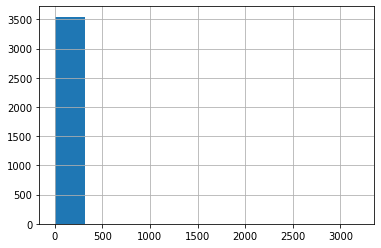

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count